In [4]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path
import pyvista as pv

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_io, utils_misc, utils_spatial_analysis, utils_correlation, utils_statistics, utils_plotting, utils_plotting_correlation, utils_plotting_spatial_mapping
import utils_plotting_cortex

from lib_data import DATA_IO
from lib_Subcortical_Atlases import Distal_Atlas

# 1. Create STN Grid and Assign LFP Channels to Grid Cells

In [6]:
# load dataframe of ECoG tapping events
ECOG_PSD_controlateral = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="controlateral")

# concat all different dyskinesia severity dataframe into single dataframe
ECOG_PSD = pd.DataFrame()
for severity in ECOG_PSD_controlateral.keys():
    ECOG_PSD = pd.concat([ECOG_PSD, ECOG_PSD_controlateral[severity]], ignore_index=True)

ECOG_PSD["severity"] = ECOG_PSD['dyskinesia_arm']

# Based on event onset time, assign no-LID events into noLID_noDOPA and noLID_DOPA groups
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] < 30)  & (ECOG_PSD['severity'] == "none"), 'severity'] = 'noLID_noDOPA'
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] >= 30) & (ECOG_PSD['severity'] == "none"), 'severity'] = 'noLID_DOPA'

# arrange the dataframe
ECOG_PSD['hemisphere'] = ECOG_PSD['ECoG_hemisphere']
ECOG_PSD['channel']    = ECOG_PSD['ECoG_channel']
ECOG_PSD = ECOG_PSD[['patient', 'hemisphere', 'channel', 
                   'pre_event_theta_mean', 'pre_event_alpha_mean', 
                   'pre_event_beta_low_mean','pre_event_beta_high_mean','pre_event_gamma_mean',
                   'event_theta_mean', 'event_alpha_mean', 
                   'event_beta_low_mean','event_beta_high_mean','event_gamma_mean', 
                   'post_event_theta_mean', 'post_event_alpha_mean',
                   'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean',
                   'severity']]

features = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean',
            'pre_event_beta_high_mean','pre_event_gamma_mean',
            'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean',
            'event_beta_high_mean','event_gamma_mean', 
            'post_event_theta_mean', 'post_event_alpha_mean',
            'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean']

# load Cortex mesh
cortex_mesh       = utils_io.load_cortical_atlas_meshes()

# load ECoG channel MNI coordinates
MNI_ECoG_channels = pd.read_pickle(DATA_IO.path_coordinates + "MNI_ECoG_channels.pkl")

# create a 3D grid around Cortex
n_bins            = 10
cortex_grid       = utils_spatial_analysis.create_3D_grid_around_anatomical_structure(cortex_mesh["right_hemisphere"], n_bins=n_bins)

# find the position of each channel in these 3D grid across x,y,z axes
MNI_ECOG_channels = utils_spatial_analysis.assign_recording_channels_to_grid_cells(MNI_ECoG_channels, cortex_grid)

# Merge information of cortex grid cells into the ECOG_PSD dataframe
# merge the data frames on 'patient', 'hemisphere', and 'channel'
ECOG_PSD = pd.merge(ECOG_PSD, 
                    MNI_ECOG_channels[['patient', 'hemisphere', 'channel', 'grid_bin_x', 'grid_bin_y', 'grid_bin_z']],
                    on=['patient', 'hemisphere', 'channel'], 
                    how='left')
ECOG_PSD = ECOG_PSD.dropna(subset=['grid_bin_x', 'grid_bin_y', 'grid_bin_z'])
ECOG_PSD["severity_numeric"] = ECOG_PSD['severity'].map({'noLID_noDOPA':0, 'noLID_DOPA':1, 'mild':2, 'moderate':3})
ECOG_PSD.reset_index(drop=True, inplace=True)

# 2. Measure & Plot the Adjusted R2 for Each Cell

In [7]:
df_R2_theta     = utils_statistics.measure_adjusted_r2_in_grid_cells_for_frequency_bands(pd.DataFrame(ECOG_PSD), n_bins=n_bins,
                                                                                         frequency_band="theta", target_feature="severity_numeric")
df_R2_beta_low  = utils_statistics.measure_adjusted_r2_in_grid_cells_for_frequency_bands(pd.DataFrame(ECOG_PSD), n_bins=n_bins,
                                                                                         frequency_band="beta_low", target_feature="severity_numeric")
df_R2_beta_high = utils_statistics.measure_adjusted_r2_in_grid_cells_for_frequency_bands(pd.DataFrame(ECOG_PSD), n_bins=n_bins,
                                                                                         frequency_band="beta_high", target_feature="severity_numeric")
df_R2_gamma     = utils_statistics.measure_adjusted_r2_in_grid_cells_for_frequency_bands(pd.DataFrame(ECOG_PSD), n_bins=n_bins,
                                                                                         frequency_band="gamma", target_feature="severity_numeric")

In [9]:
grid_bin_center_coordianates    = utils_spatial_analysis.extract_grid_cell_centers(cortex_grid, n_bins)
cortex_dynamics                 = pd.DataFrame(grid_bin_center_coordianates)

cortex_dynamics                 = cortex_dynamics.merge(df_R2_theta, left_on=['grid_bin_x', 'grid_bin_y','grid_bin_z'], right_on=['grid_bin_x', 'grid_bin_y','grid_bin_z'], how='left')
cortex_dynamics['R2_theta']     = cortex_dynamics['adjusted_r2']
cortex_dynamics                 = cortex_dynamics.drop(columns=['adjusted_r2','frequency_band'])

cortex_dynamics                 = cortex_dynamics.merge(df_R2_beta_low, left_on=['grid_bin_x', 'grid_bin_y','grid_bin_z'], right_on=['grid_bin_x', 'grid_bin_y','grid_bin_z'], how='left')
cortex_dynamics['R2_beta_low']  = cortex_dynamics['adjusted_r2']
cortex_dynamics                 = cortex_dynamics.drop(columns=['adjusted_r2','frequency_band'])

cortex_dynamics                 = cortex_dynamics.merge(df_R2_beta_high, left_on=['grid_bin_x', 'grid_bin_y','grid_bin_z'], right_on=['grid_bin_x', 'grid_bin_y','grid_bin_z'], how='left')
cortex_dynamics['R2_beta_high'] = cortex_dynamics['adjusted_r2']
cortex_dynamics                 = cortex_dynamics.drop(columns=['adjusted_r2','frequency_band'])

cortex_dynamics                 = cortex_dynamics.merge(df_R2_gamma, left_on=['grid_bin_x', 'grid_bin_y','grid_bin_z'], right_on=['grid_bin_x', 'grid_bin_y','grid_bin_z'], how='left')
cortex_dynamics['R2_gamma']     = cortex_dynamics['adjusted_r2']
cortex_dynamics                 = cortex_dynamics.drop(columns=['adjusted_r2','frequency_band'])

cortex_dynamics["x"]            = cortex_dynamics["grid_bin_center_x"]
cortex_dynamics["y"]            = cortex_dynamics["grid_bin_center_y"]
cortex_dynamics["z"]            = cortex_dynamics["grid_bin_center_z"]

cortex_dynamics.replace(np.nan, 0, inplace=True)

cortex_dynamics                 = cortex_dynamics.loc[~(cortex_dynamics[['R2_theta', 'R2_beta_low', 'R2_beta_high', 'R2_gamma']] == 0).all(axis=1)]

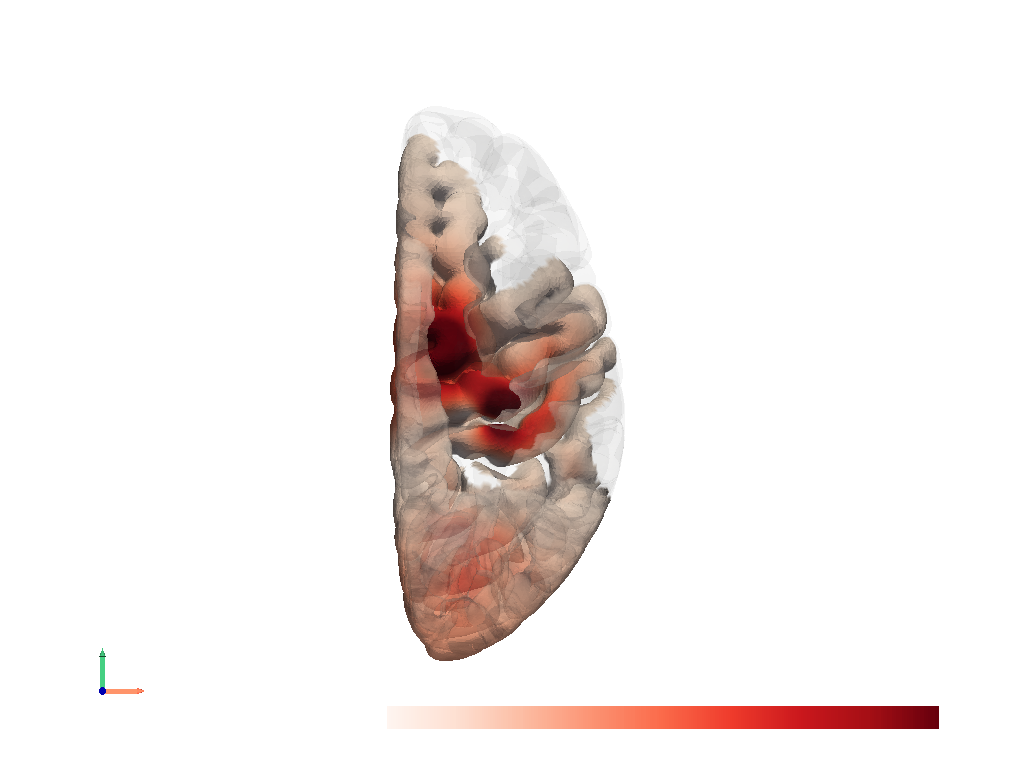

In [15]:
band                 = "gamma"
cortex_activity_mesh = utils_plotting_spatial_mapping.map_electrophysiological_activity_to_anatomical_surface(cortex_dynamics, 
                                                                                                              cortex_mesh["right_hemisphere"], 
                                                                                                              function='linear', 
                                                                                                              epsilon=5)
plotter              = utils_plotting_spatial_mapping.plot_cortical_activity_distribution(cortex_mesh["right_hemisphere"], cortex_activity_mesh, feature=band, 
                                                                                          cmap="Reds", clim=[0.0, 0.3], file_path=DATA_IO.path_figure + "ECOG_Maps/")
